### Training and Testing of the Baseline and HNN Models on an Ideal Pendulum System

In [101]:
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg


In [102]:
import scipy.integrate 
solve_ivp = scipy.integrate.solve_ivp

In [103]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from baseline_models import BaselineMLP
from hnn import HNN 
from utils import L2Loss, rk4

In [104]:
import utils 
print(dir(utils))

['L2Loss', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'np', 'rk4', 'scipy', 'solve_ivp', 'torch']


In [105]:
from data import get_dataset, get_field, trajectory

### Which Loss Function to choose for this? 

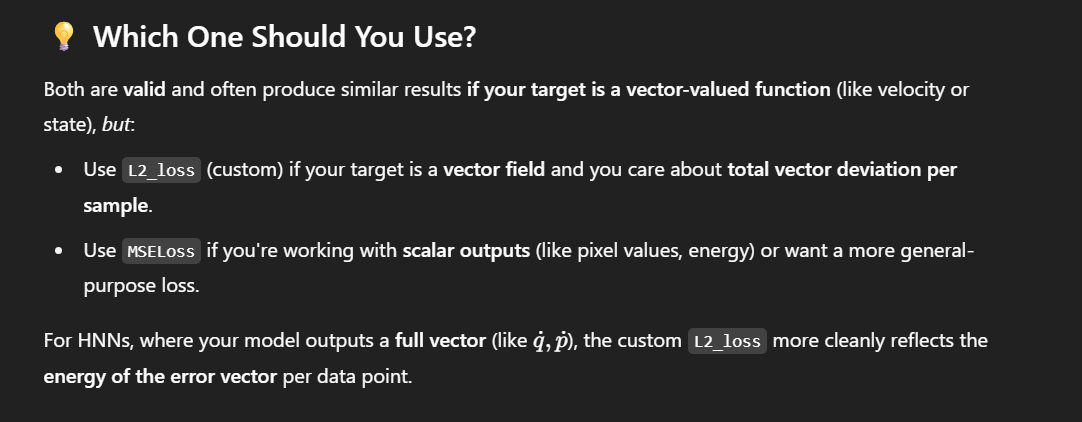

In [106]:


torch.manual_seed(0)
np.random.seed(0)

#according to the paper and my intuition, initializing the model and optimizer
input_dim = 2
hidden_dim = 200 
output_dim = 2 

nn_model = BaselineMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim)
#baseline_model = HNN(input_dim=input_dim, differentiable_model=nn_model, baseline=True)
baseline_model = BaselineMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim)
model = HNN(input_dim=input_dim, differentiable_model=nn_model)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
base_optim = torch.optim.Adam(baseline_model.parameters(), lr=1e-3, weight_decay=1e-4)


In [107]:
#arranging the data and turning them to tensors 
data = get_dataset(seed=0)
x_train = torch.tensor(data['train_x'], requires_grad=True, dtype=torch.float32) #z = [q p]
x_test = torch.tensor(data['test_x'], requires_grad=True, dtype=torch.float32)
dxdt_train = torch.tensor(data['train_dx']) #z' = [q' p'], these are the targets
dxdt_test= torch.tensor(data['test_dx']) 

### Inspecting the Dataset 

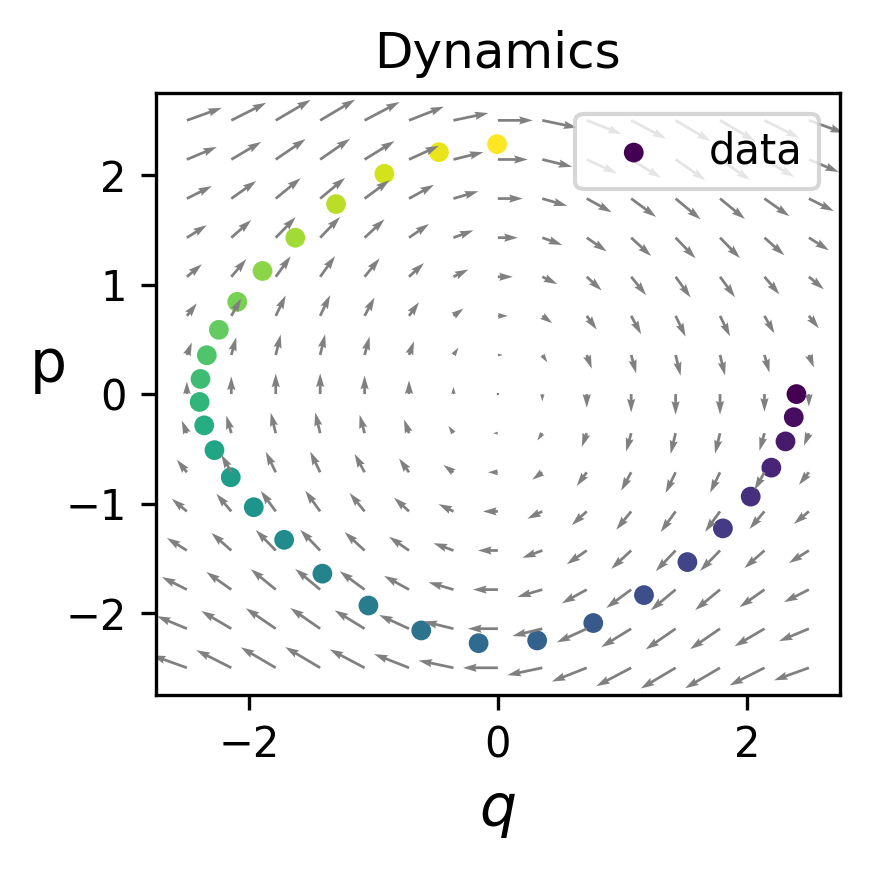

In [108]:
field = get_field(xmin=-2.5, xmax=2.5, ymin=-2.5, ymax=2.5, gridsize=15)
data = get_dataset(seed=0)

fig = plt.figure(figsize=(3,3), facecolor='white', dpi=300)

# Get trajectory data
q, p, dqdt, dpdt, t_eval = trajectory(radius=2.4, y0=np.array([2,0]), noise_std=0)
x, y, dx, dy, t = q.squeeze(), p.squeeze(), dqdt.squeeze(), dpdt.squeeze(), t_eval

# Plot trajectory
plt.scatter(x, y, c=t, s=14, label='data')

# Plot vector field
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1], 
           cmap='gray_r', color=(.5,.5,.5))

plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show() 

### Training and Testing

In [109]:
#normal training loop
epochs = 2000 
stats = {'training_loss':[], 'testing_loss':[] }
for epoch in range(epochs):

    baseline_model.train()

    dxdt_hat_train = baseline_model(x_train)

    train_loss = L2Loss(dxdt_train, dxdt_hat_train)
    stats['training_loss'].append(train_loss)

    base_optim.zero_grad()

    train_loss.backward()

    base_optim.step()

    #testing 
    baseline_model.eval()
    with torch.inference_mode():
        # print(x_test.shape)
        # print(dxdt_hat_train.shape)
        x_test.requires_grad_(True) #enable gradient tracking for the in graph gradient
        dxdt_hat_test = baseline_model(x_test) 
        test_loss = L2Loss(dxdt_hat_test, dxdt_test)
        stats['testing_loss'].append(test_loss)
    
    if epoch % 10 == 0 :
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}  | Test Loss: {test_loss:.5f} ")
    

Epoch: 0 | Train Loss: 6.01374  | Test Loss: 5.40281 
Epoch: 10 | Train Loss: 1.57044  | Test Loss: 1.25027 
Epoch: 20 | Train Loss: 0.34650  | Test Loss: 0.34395 
Epoch: 30 | Train Loss: 0.43674  | Test Loss: 0.36094 
Epoch: 40 | Train Loss: 0.31672  | Test Loss: 0.29303 
Epoch: 50 | Train Loss: 0.30663  | Test Loss: 0.27144 
Epoch: 60 | Train Loss: 0.29421  | Test Loss: 0.26225 
Epoch: 70 | Train Loss: 0.28376  | Test Loss: 0.25364 
Epoch: 80 | Train Loss: 0.27770  | Test Loss: 0.24987 
Epoch: 90 | Train Loss: 0.26896  | Test Loss: 0.24175 
Epoch: 100 | Train Loss: 0.25970  | Test Loss: 0.23339 
Epoch: 110 | Train Loss: 0.24879  | Test Loss: 0.22396 
Epoch: 120 | Train Loss: 0.23580  | Test Loss: 0.21184 
Epoch: 130 | Train Loss: 0.22044  | Test Loss: 0.19737 
Epoch: 140 | Train Loss: 0.20244  | Test Loss: 0.18037 
Epoch: 150 | Train Loss: 0.18179  | Test Loss: 0.16087 
Epoch: 160 | Train Loss: 0.15906  | Test Loss: 0.13967 
Epoch: 170 | Train Loss: 0.13537  | Test Loss: 0.11784 
Epo

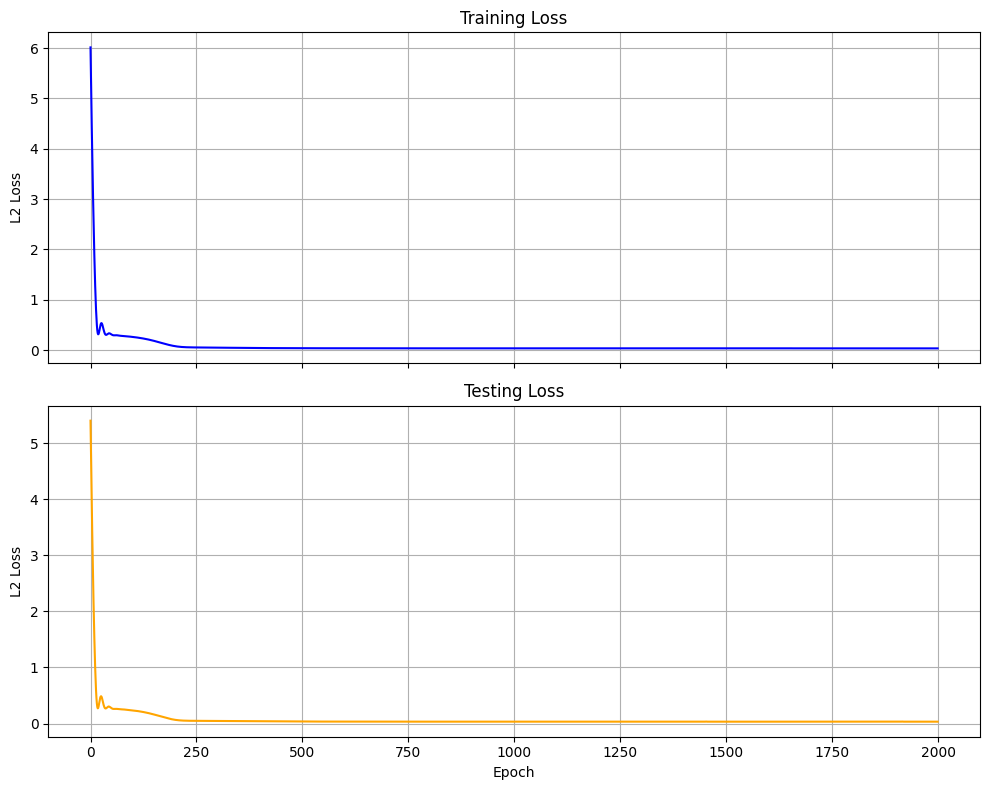

In [110]:
# Convert loss tensors to floats
train_losses = [loss.item() for loss in stats['training_loss']]
test_losses = [loss.item() for loss in stats['testing_loss']]

# Create two subplots: one for training loss, one for testing loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
axs[0].plot(train_losses, color='blue')
axs[0].set_title('Training Loss')
axs[0].set_ylabel('L2 Loss')
axs[0].grid(True)

# Plot testing loss
axs[1].plot(test_losses, color='orange')
axs[1].set_title('Testing Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 Loss')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [111]:
#normal training loop
epochs = 2000 
stats = {'training_loss':[], 'testing_loss':[] }
for epoch in range(epochs):

    model.train()

    dxdt_hat_train = model.time_derivative(x_train)

    train_loss = L2Loss(dxdt_train, dxdt_hat_train)
    stats['training_loss'].append(train_loss)

    optim.zero_grad()

    train_loss.backward()

    optim.step()

    #testing 
   
    x_test.requires_grad_(True) #enable gradient tracking for the in graph gradient
    dxdt_hat_test = model.time_derivative(x_test) 
    test_loss = L2Loss(dxdt_hat_test, dxdt_test)
    stats['testing_loss'].append(test_loss)
    
    if epoch % 10 == 0 :
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}  | Test Loss: {test_loss:.5f} ")
    

Epoch: 0 | Train Loss: 6.14754  | Test Loss: 6.01021 
Epoch: 10 | Train Loss: 5.45645  | Test Loss: 5.35458 
Epoch: 20 | Train Loss: 4.27185  | Test Loss: 4.10380 
Epoch: 30 | Train Loss: 2.23481  | Test Loss: 2.02893 
Epoch: 40 | Train Loss: 0.45854  | Test Loss: 0.36510 
Epoch: 50 | Train Loss: 0.12357  | Test Loss: 0.11685 
Epoch: 60 | Train Loss: 0.09013  | Test Loss: 0.09011 
Epoch: 70 | Train Loss: 0.05911  | Test Loss: 0.05529 
Epoch: 80 | Train Loss: 0.04889  | Test Loss: 0.04247 
Epoch: 90 | Train Loss: 0.04291  | Test Loss: 0.03946 
Epoch: 100 | Train Loss: 0.04040  | Test Loss: 0.03862 
Epoch: 110 | Train Loss: 0.03893  | Test Loss: 0.03688 
Epoch: 120 | Train Loss: 0.03790  | Test Loss: 0.03602 
Epoch: 130 | Train Loss: 0.03721  | Test Loss: 0.03560 
Epoch: 140 | Train Loss: 0.03670  | Test Loss: 0.03511 
Epoch: 150 | Train Loss: 0.03632  | Test Loss: 0.03487 
Epoch: 160 | Train Loss: 0.03601  | Test Loss: 0.03469 
Epoch: 170 | Train Loss: 0.03577  | Test Loss: 0.03453 
Epo

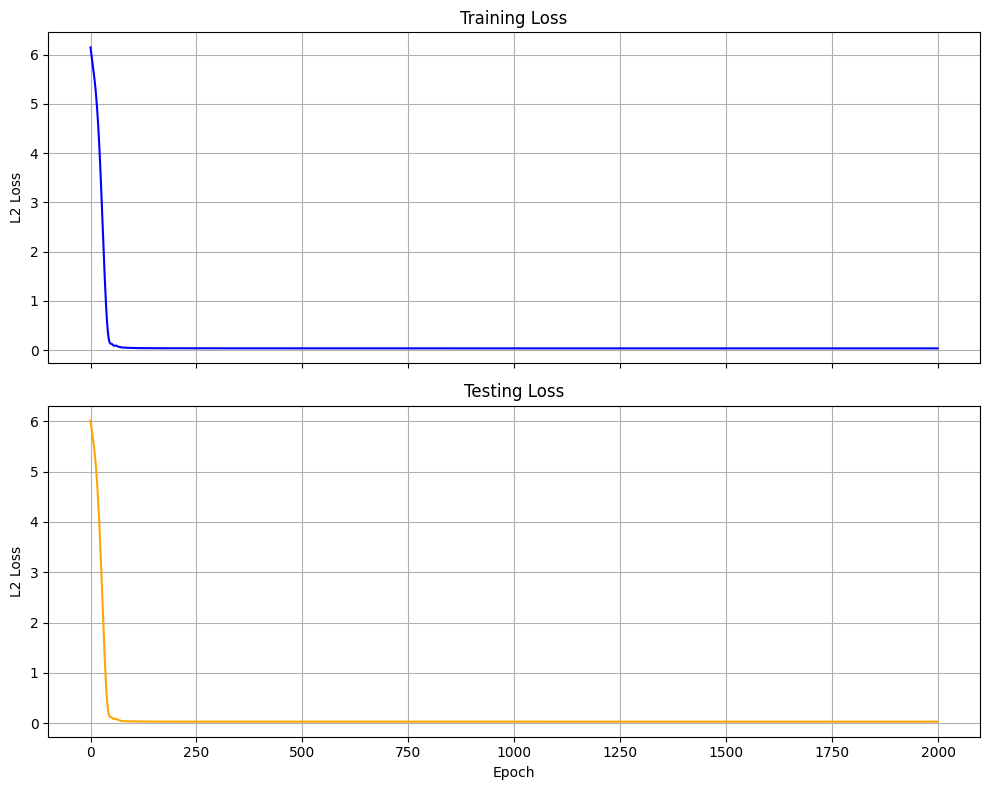

In [112]:
# Convert loss tensors to floats
train_losses = [loss.item() for loss in stats['training_loss']]
test_losses = [loss.item() for loss in stats['testing_loss']]

# Create two subplots: one for training loss, one for testing loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
axs[0].plot(train_losses, color='blue')
axs[0].set_title('Training Loss')
axs[0].set_ylabel('L2 Loss')
axs[0].grid(True)

# Plot testing loss
axs[1].plot(test_losses, color='orange')
axs[1].set_title('Testing Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 Loss')
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Run Analysis

In [113]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']

    #running the model 
    mesh_x = torch.tensor(np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

In [114]:
def baseline_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']

    #running the model 
    mesh_x = torch.tensor(np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model(mesh_x)
    return mesh_dx.data.numpy()

In [115]:
def integrate_model(model, t_span, y0, **kwargs):

    def fun(t, np_x):
        x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx 
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [126]:
def baseline_integrate_model(model, t_span, y0, **kwargs):

    def fun(t, np_x):
        x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32).view(1,2).requires_grad_(True)
        dx = model(x).data.numpy().reshape(-1)
        return dx 
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [127]:
R = 2.6
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=10)
data = get_dataset(radius=2.0,seed=0)

#getting the vector fields
baseline_field = baseline_vector_field(baseline_model,xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=10)
hnn_field = get_vector_field(model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=10)

#integrating along those fields starting from point (1,0)
t_span = [0,28]
y0 = np.asarray([2.1,0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = baseline_integrate_model(baseline_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(model, t_span, y0, **kwargs)

In [128]:
base_ivp, hnn_ivp 


(  message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 0.000e+00  2.803e-02 ...  2.797e+01  2.800e+01]
         y: [[ 2.100e+00  2.098e+00 ... -1.138e+00 -1.214e+00]
             [ 0.000e+00 -7.213e-02 ... -1.394e+00 -1.316e+00]]
       sol: None
  t_events: None
  y_events: None
      nfev: 1682
      njev: 0
       nlu: 0,
   message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 0.000e+00  2.803e-02 ...  2.797e+01  2.800e+01]
         y: [[ 2.100e+00  2.098e+00 ...  1.850e+00  1.894e+00]
             [ 0.000e+00 -7.230e-02 ...  8.232e-01  7.429e-01]]
       sol: None
  t_events: None
  y_events: None
      nfev: 1694
      njev: 0
       nlu: 0)

In [129]:
print("field['x'].shape:", field['x'].shape)           # → (N, 2)
print("baseline_field.shape:", baseline_field.shape)   # → should also be (N, 2)

print("Any NaNs?", np.isnan(baseline_field).any())
print("baseline_field min/max:", baseline_field.min(), baseline_field.max())


field['x'].shape: (100, 2)
baseline_field.shape: (100, 2)
Any NaNs? False
baseline_field min/max: -5.0060406 4.9881573


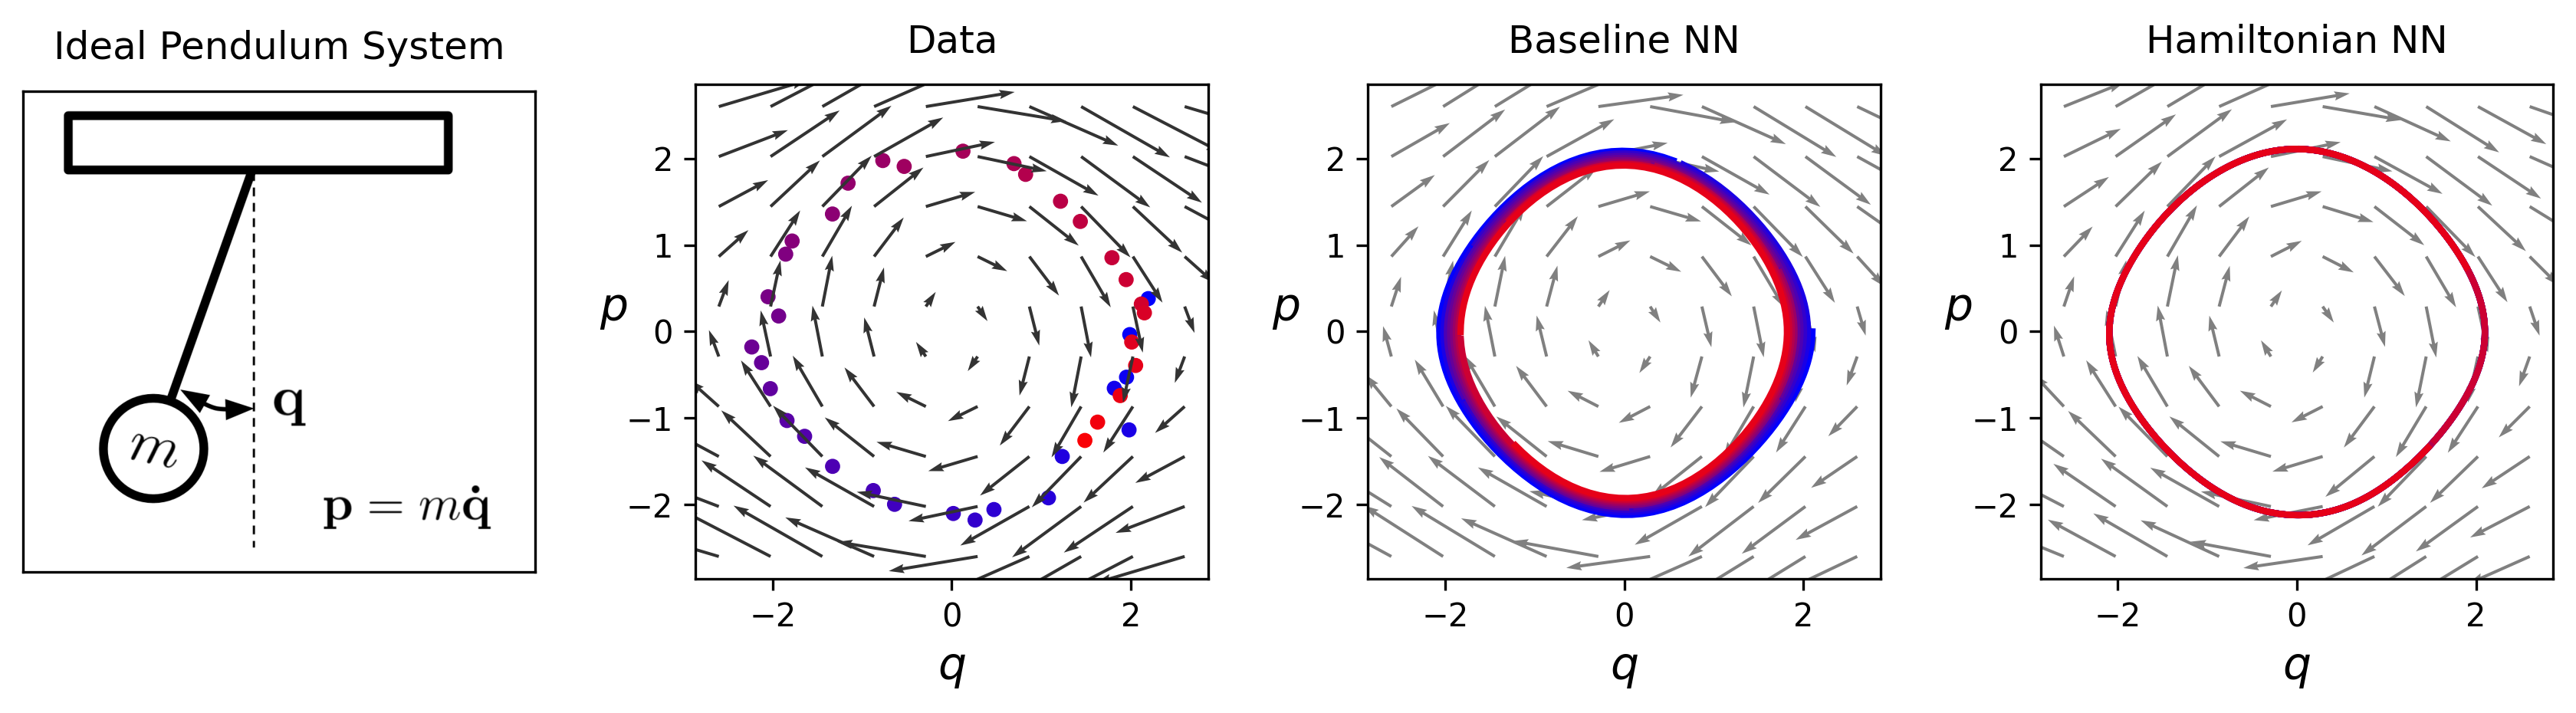

In [130]:
#Plotting the results 
fig = plt.figure(figsize=(11.3,3.2), facecolor='white', dpi=300)

#plot physical system 
fig.add_subplot(1,4,1, frameon=True)
plt.xticks([]) ; plt.yticks([])
schema = mpimg.imread(r'C:\Users\Neel\ResearchProjects\Hamiltonian_Neural_Networks\experiment_pendulum\pendulum.png')
plt.imshow(schema, cmap='gray')
plt.title("Ideal Pendulum System", pad=10)

#plot dynamics 
fig.add_subplot(1,4,2,frameon=True)
x,y, dx, dy, t = trajectory(t_span=[0,4], radius=2.1, y0=y0)
N = len(x)
point_colours = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=14, label='data', c=point_colours)
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1], 
           cmap='gray_r', scale=30, width=6e-3, color=(.2,.2,.2))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

#plot baseline 
fig.add_subplot(1, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], baseline_field[:,0], baseline_field[:,1],
        cmap='gray_r', scale=30, width=6e-3, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, 10)):
    color = (float(i)/10, 0, 1-float(i)/10)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=2)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

#plot HNN
fig.add_subplot(1,4,4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1], 
           cmap='gray_r', scale=30, width=6e-3, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, 10)):
    colour = (float(i)/10,0, 1-float(i)/10)
    plt.plot(l[:,0], l[:,1], color=colour, linewidth=2)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

plt.tight_layout(w_pad=2.0)  


### Quantitative Analysis 

* Choosing trajectories from the test set 
* Measuring vector field loss at each point 
* Integrating along trajectory and measuring mean loss between points

In [131]:
from data import dynamics, hamiltonian

In [132]:
def integrate_models(x0=np.asarray([1,0]), t_span=[0,5], t_eval=None, noise_std=0.1):
    #integration along ground truth vector field 
    kwargs = {'t_eval':t_eval, 'rtol':1e-12}
    true_path = solve_ivp(fun=dynamics, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T 

    #rescale time to compensate for noise effects,
    t_span[1] *= 1 + 0.9*noise_std 
    t_eval *= 1 + 0.9*noise_std

    #integration along baseline vector field 
    base_path = baseline_integrate_model(nn_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T 
    _tmp = torch.tensor(true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    return true_x, base_x, hnn_x 

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)

    return np.mean((true_energy-integration_energy)**2)


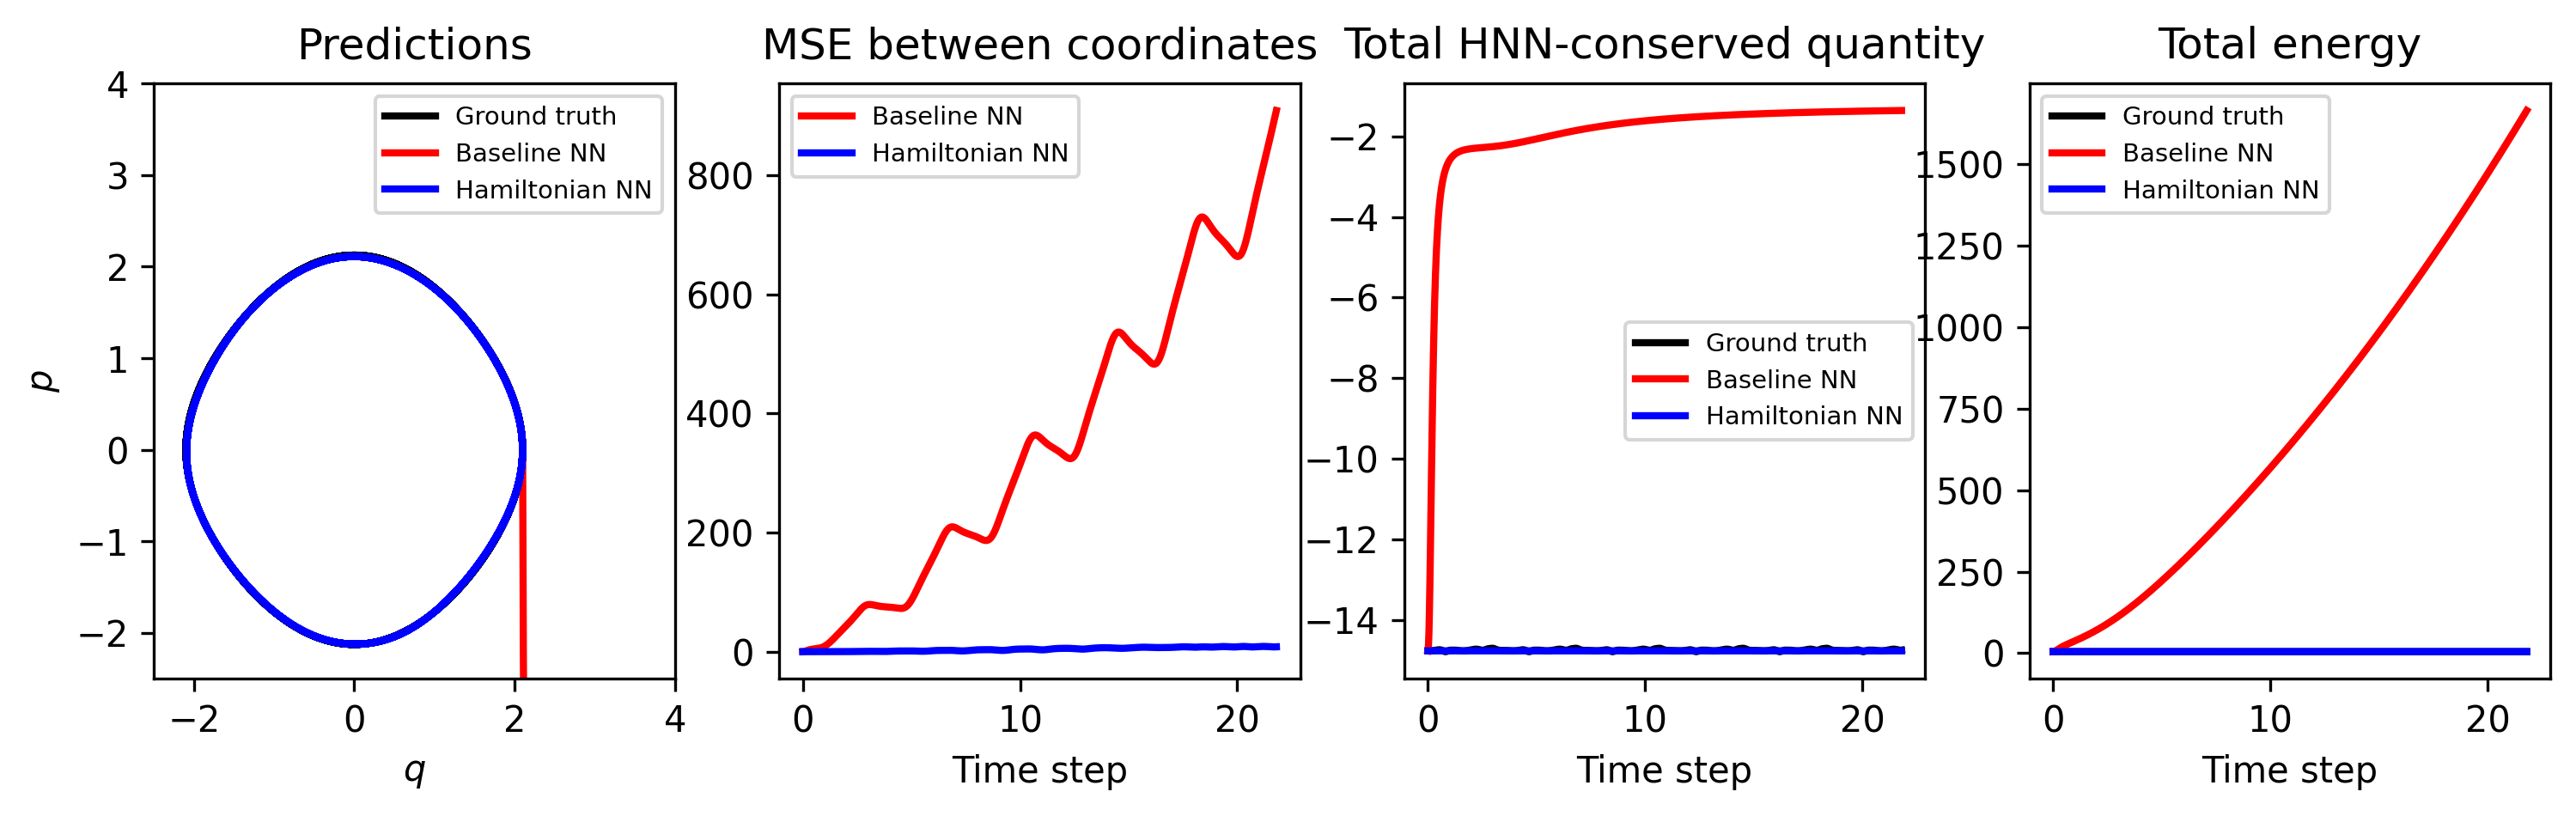

In [133]:
x0 = np.asarray([2.1, 0])

# integration
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=300)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.xlim(-2.5,4) ; plt.ylim(-2.5,4)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
base_hq = model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
hnn_hq = model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian(c) for c in true_x])
base_e = np.stack([hamiltonian(c) for c in base_x])
hnn_e = np.stack([hamiltonian(c) for c in hnn_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)


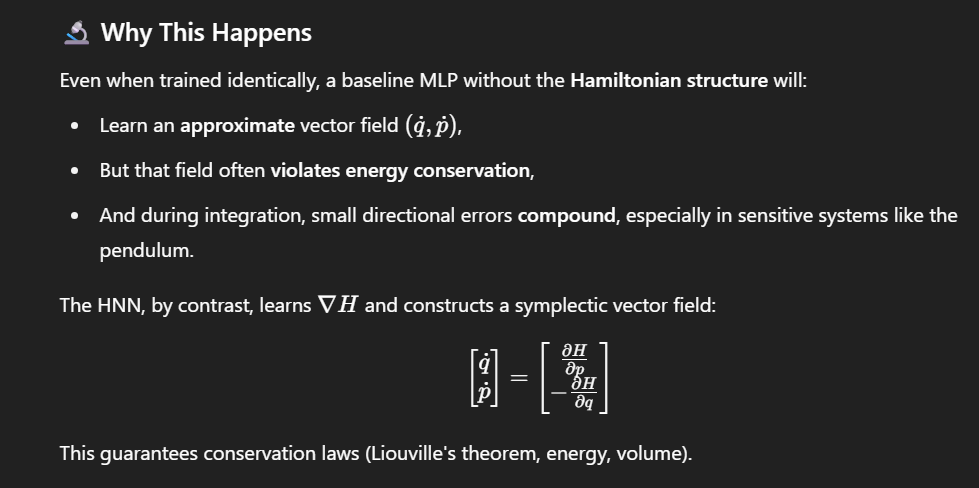

In [124]:
splits = 5
samples = 3
losses = {'base_energy' : [], 'hnn_energy' : []}
t_eval = np.linspace(t_span[0], t_span[1], 100)

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(2)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    
    losses['base_energy'] += [ energy_loss(true_x, base_x) ]
    losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
    print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

In [125]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_energy']), bootstrap_conf(losses['base_energy'], splits),
          np.mean(losses['hnn_energy']), bootstrap_conf(losses['hnn_energy'], splits))
     )


Baseline NN energy MSE: 1.3970e+07 +/- 6.18e+06
Hamiltonian NN energy MSE: 2.5635e-02 +/- 5.45e-03
